Imports

In [2]:
# General

from scipy import stats
import scipy
from skimage.filters import threshold_otsu, rank
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import binary_erosion, binary_dilation, disk, square
import pandas as pd
import sys
from scipy import ndimage
from datacube import helpers
from datacube.utils import geometry
from matplotlib.patches import Rectangle

# PCA

# import sklearn
sys.path.append('/g/data/u46/users/sc0554/cult_area/LCCS/')

# Image Seg

from skimage import io
from skimage.segmentation import quickshift, felzenszwalb
import sklearn.feature_extraction.image
import sklearn.cluster
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.util import img_as_float
from skimage.color import rgb2gray
from sklearn.impute import SimpleImputer
from skimage.filters import sobel

In [3]:
import datacube
dc=datacube.Datacube(config='/home/547/sc0554/datacube.conf', env='lccs_dev')

In [4]:
# product = 'ls8_nbart_tmad_annual'


# # Ayr
# x = (1500000, 1600000)
# y = (-2200000, -2100000)

# # Diamentina
# x = (800000, 900000)
# y = (-2800000, -2700000)

# # Gwydir
x = (1600000, 1700000)
y = (-3400000, -3300000)

# # Leichhardt
# x = (800000, 900000)
# y = (-2000000, -1900000)

# # Kakadu
# x = (0, 100000)
# y = (-1350000, -1250000)

# # Hobart
# x = (1200000, 1300000)
# y = (-4800000, -4700000)

# # Perth
# x = (-1550000, -1450000)
# y = (-3650000, -3550000)

# # Murray Valley
# x = (1100000, 1200000)
# y = (-4000000, -3900000)

# Adelaide
# x = (550000, 650000)
# y = (-3850000, -3750000)

# Canberra
# x = (1500000, 1600000)
# y = (-4000000, -3900000)
# min_x = 1500000
# max_x = 1600000
# min_y = -4000000
# max_y = -3900000
# res_x = 25
# res_y = -25


# # Lake Eyre
# x = (500000, 600000)
# y = (-3000000, -2900000)

# # Blue mountains
# x = (1600000, 1700000)
# y = (-3900000, -3800000)

# # Australian Alps
# x = (1400000, 1500000)
# y = (-4100000, -4000000)

# # Collier Range
# x = (-1300000, -1200000)
# y = (-2700000, -2600000)

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)

# # Brisbane
# x = (2000000, 2100000)
# y = (-3200000, -3100000)

# # Dundas
# x = (-1000000, -900000)
# y = (-3650000, -3550000)

query = {'time': ('2015-01-01', '2015-12-31')}
query['x'] = (x[0], x[1])
query['y'] = (y[0], y[1])
query['crs'] = 'EPSG:3577'

# Median Absolute Deviation

In [20]:
# Load data
tmad = dc.load(product='ls8_nbart_tmad_annual', **query)
tmad = tmad.isel(time=0)
tmad = tmad.drop('time')

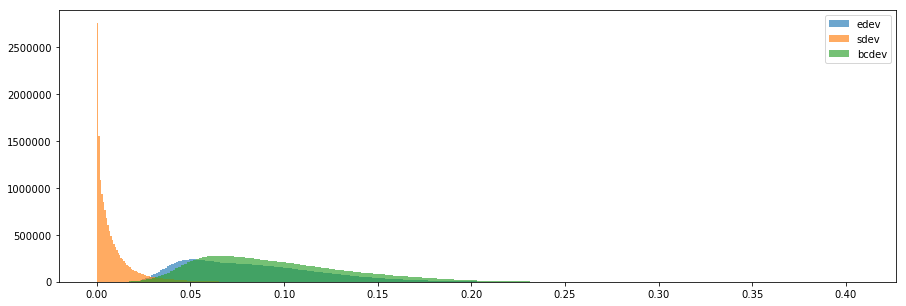

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(tmad['edev'].data.ravel(), bins=256, label='edev', alpha=0.65)
ax.hist(tmad['sdev'].data.ravel(), bins=256, label='sdev', alpha=0.65)
ax.hist(tmad['bcdev'].data.ravel(), bins=256, label='bcdev', alpha=0.65)

ax.legend(prop={'size': 10})

In [22]:
print('# of edev NaNs', np.isnan(tmad.edev.data).sum())
print('# of edev 0s', (tmad.edev == 0).sum().data)
print('# of sdev NaNs', np.isnan(tmad.sdev.data).sum())
print('# of sdev 0s', (tmad.sdev == 0).sum().data)
print('# of bcdev NaNs', np.isnan(tmad.bcdev.data).sum())
print('# of bcdev 0s', (tmad.bcdev == 0).sum().data)

# of edev NaNs 0
# of edev 0s 0
# of sdev NaNs 0
# of sdev 0s 0
# of bcdev NaNs 0
# of bcdev 0s 0


In [23]:
# Extract data from xarray, impute NaNs and apply log transform

imp_0 = SimpleImputer(missing_values=0, strategy='mean')

container = {}
for key in tmad.data_vars:
    d = tmad[key].data.squeeze()
    d = np.nan_to_num(d)
    d = np.where(d < 0, 0, d)
    d = np.where(d == 1, 0, d)
    imp_0.fit(d)
    d = imp_0.transform(d)
    d = -np.log(d)
    container.update({key:d})

In [24]:
tmad['edev'].data = container['edev']
tmad['sdev'].data = container['sdev']
tmad['bcdev'].data = container['bcdev']

In [25]:
tmad_mean = np.float64(np.mean(np.stack([tmad.edev.data, tmad.sdev.data, tmad.bcdev.data], axis=-1), axis=-1))

In [26]:
thresh = np.percentile(tmad_mean.ravel(), 10)
print(thresh)

2.6155218839645387


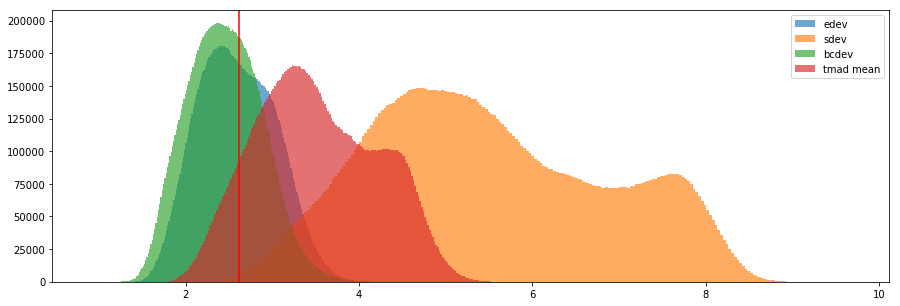

In [27]:
# Plot the distributions of of the data and threshold

fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(tmad['edev'].data.ravel(), bins=256, label='edev', alpha=0.65)
ax.hist(tmad['sdev'].data.ravel(), bins=256, label='sdev', alpha=0.65)
ax.hist(tmad['bcdev'].data.ravel(), bins=256, label='bcdev', alpha=0.65)
ax.hist(tmad_mean.ravel(), bins=256, label='tmad mean', alpha=0.65)
ax.axvline(thresh, color='r')

ax.legend(prop={'size': 10})

In [121]:
# Segment input array

# %%time
# Note: convert2lab=False allows the use of multiband images
tmad_seg = quickshift(tmad_mean, kernel_size=7, convert2lab=False, max_dist=500, ratio=0.5)
print("Quickshift number of segments: %d" % len(np.unique(tmad_seg)))

Quickshift number of segments: 4227


In [122]:
# Calculate the median for each segment

tmad_median_seg = scipy.ndimage.median(input=tmad_mean, labels=tmad_seg, index=tmad_seg)

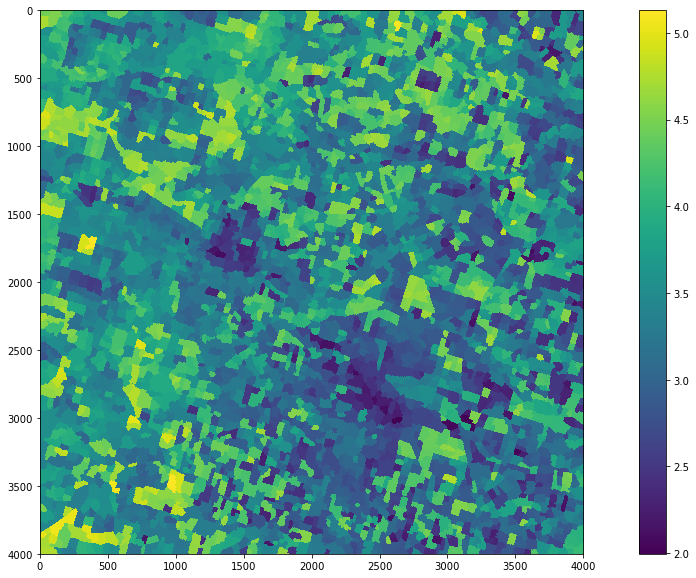

In [123]:
# Plot the median - segments output

fig, ax = plt.subplots(ncols=1, figsize=(20,10))
plt.imshow(tmad_median_seg)
plt.colorbar()

In [33]:
# Calculate the optimum threshold 
# thresh = threshold_otsu(tmad_np) 
# Filter by the threshold
tmad_thresh = tmad_median_seg < thresh
# Convert boolean values to binary 1's and 0's
tmad_thresh = tmad_thresh*1
tmad_thresh = tmad_thresh.astype(float)

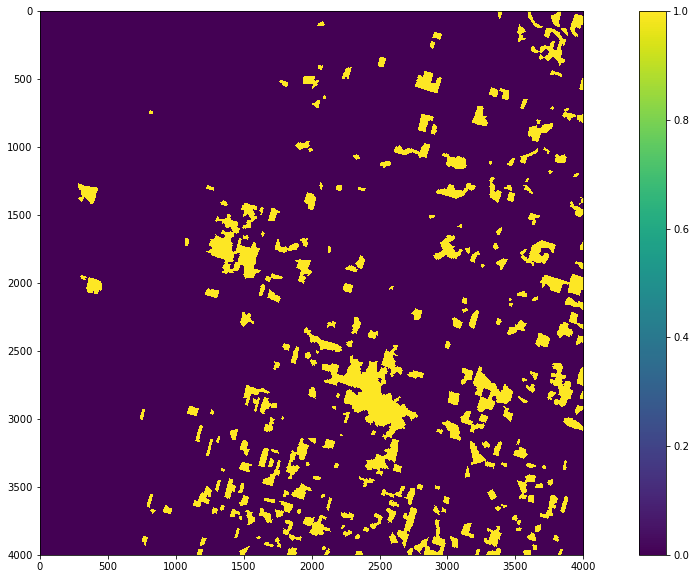

In [34]:
# Plot final output
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
plt.imshow(tmad_thresh)
plt.colorbar()

# Vegetation

In [5]:
# Load fractional cover data

fc_data = xr.open_dataset('netcdfs/gwydirfc.nc')
# fc = dc.load(product = 'fc_percentile_albers_annual', **query)

In [6]:
# Create a mask to show areas where total vegetation is greater than the baresoil fraction of a pixel for each scene
tv_mask = fc_data['BS'] < (fc_data['PV'])# + fc_data['NPV'])
tv = tv_mask.where(fc_data['PV'] > 0)

# Calculate the proportion of time where total vegetatoin is greater than the bare soil fraction of a pixel for the input year
tv_summary = tv.mean(dim='time')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


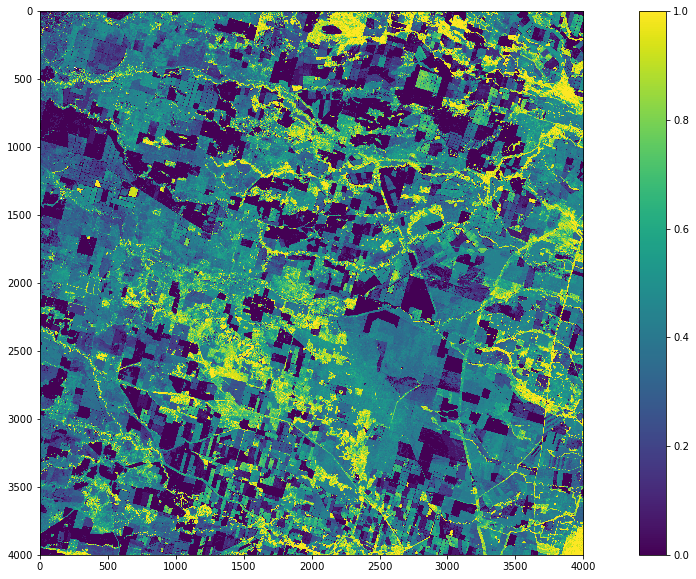

In [7]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
plt.imshow(tv_summary)
plt.colorbar()

In [ ]:
# import seaborn as sns
# x = tv_summary.data
# y = tmad_pca
# with sns.axes_style("white"):
#     sns.jointplot(x=x, y=y, kind="hex", color="k");

In [8]:
# Segment the numpy array

# %%time
# Note: convert2lab=False allows the use of multiband images
seg = quickshift(tv_summary, kernel_size=10, convert2lab=False, max_dist=500, ratio=0.5)
print("Quickshift number of segments: %d" % len(np.unique(seg)))

Quickshift number of segments: 125572


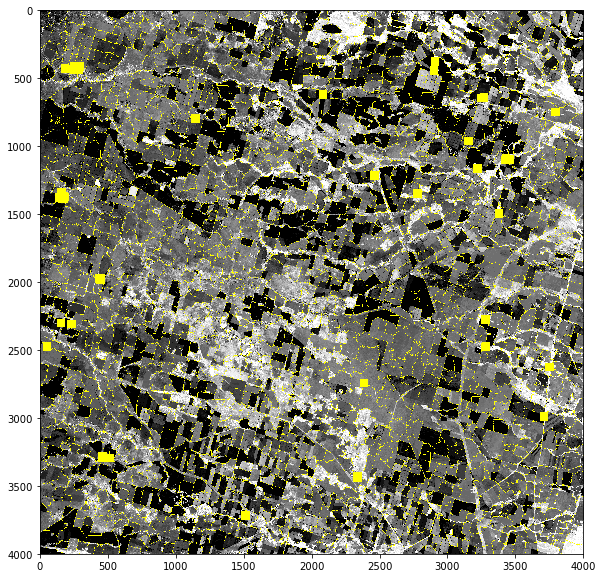

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mark_boundaries(tv_summary, seg))

In [10]:
# Calculate the median max ndvi value for each segment
import scipy
tv_summary_seg = scipy.ndimage.median(input=tv_summary, labels=seg, index=seg)

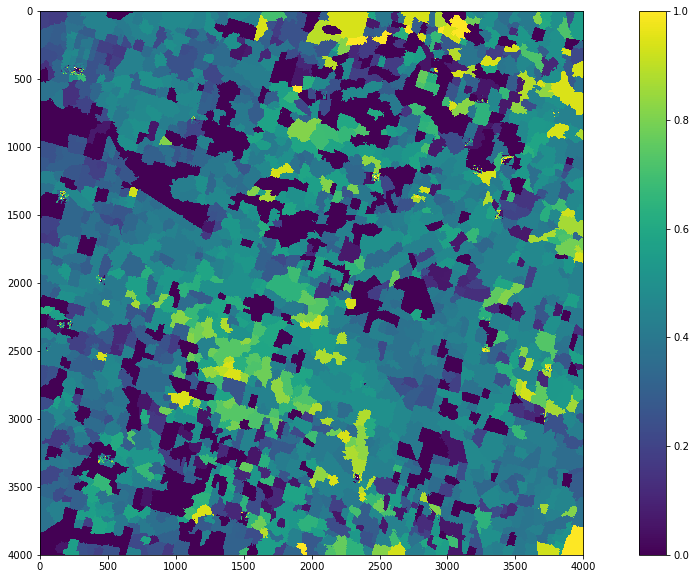

In [11]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
plt.imshow(tv_summary_seg)
plt.colorbar()

In [12]:
# Filter the segmented summary based on the proportion of time spent dominated by vegetatoin
tv_summary_filt = (tv_summary_seg > .3) & (tv_summary_seg < .9)
tv_summary_filt = tv_summary_filt*1
tv_summary_filt = tv_summary_filt.astype(float)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


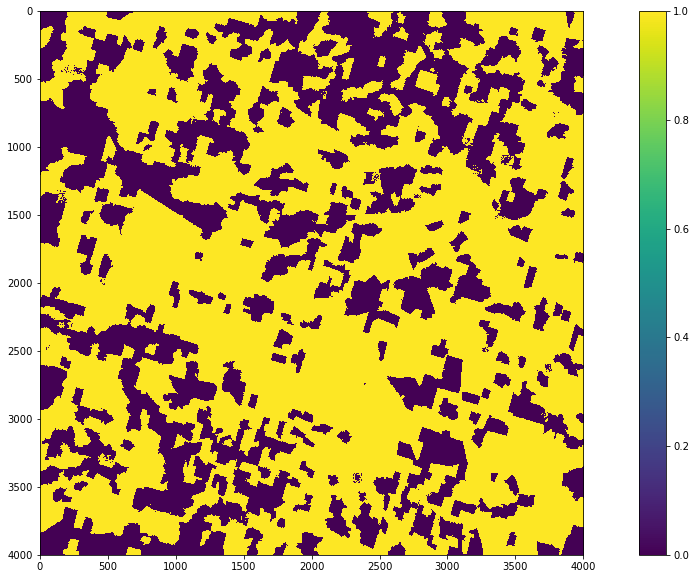

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
plt.imshow(tv_summary_filt)
plt.colorbar()

In [161]:
# Create an empty numpy array with the same shape as the input
# img_fill = np.ones((tv_summary.shape))
# Assign the segment size values to each value belonging to that 
# seg_size = scipy.ndimage.sum(input=img_fill, labels=seg, index=seg)
# print(np.unique(seg_size))

[1.0000e+00 5.8400e+02 6.0100e+02 ... 1.8057e+04 2.5150e+04 2.5370e+04]


In [162]:
# Filter by segment size
# tv_summary_filt_seg = np.where((seg_size > 500) & (seg_size < 19000), tv_summary_filt, 0)

NameError: name 'tv_summary_filt_seg' is not defined

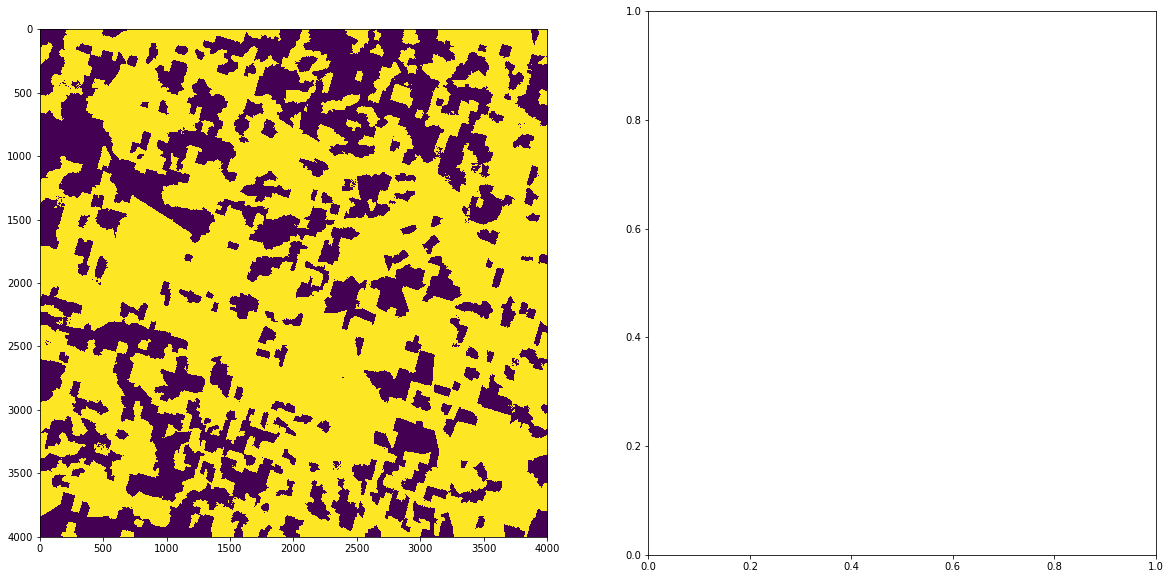

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(tv_summary_filt)
ax[1].imshow(tv_summary_filt_seg)

## Combining Steps

In [164]:
cult_area = np.logical_and(tmad_thresh, tv_summary_filt)

In [297]:
from skimage.measure import label, regionprops

# Give segments unique labels
labeled = label(cult_area, connectivity = 1)

# Create list of labels that do not meet the desired shape requirements
fracdim = {}
labels = []
for region in regionprops(labeled):
#     solidity = region.convex_area / region.area
    fractal_dimension = 2*np.log(region.perimeter/4)/np.log(region.area)
#     rect = region.area/(region.major_axis_length*region.minor_axis_length)
    fracdim[region.label] = fractal_dimension
    if ((fractal_dimension > 1.09)&(fractal_dimension > 1)) or region.area < 100:
        labels.append(region.label)

# Create a mask using labels
mask = np.isin(labeled, labels)

# Mask the array 
cult_area_fractal = np.ma.masked_array(cult_area, mask)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [186]:
# Optional morphology steps
# cult_area_filt = ndimage.median_filter(cult_area, 4)
# cult_area_filt = np.where(cult_area_filt == True, 1, 0).astype(float)
# ero_cult = binary_erosion(cult_area, square(2))
# dil_cult = binary_dilation(ero_cult, square(2))

In [1]:
%%time
x = np.vectorize(fracdim.get)(seg)
print(x)

NameError: name 'np' is not defined

In [274]:
fracdimarray = labeled.copy().astype(float)
for label in fracdim:
    fracdimarray[fracdimarray == label - 1] = fracdim[label]

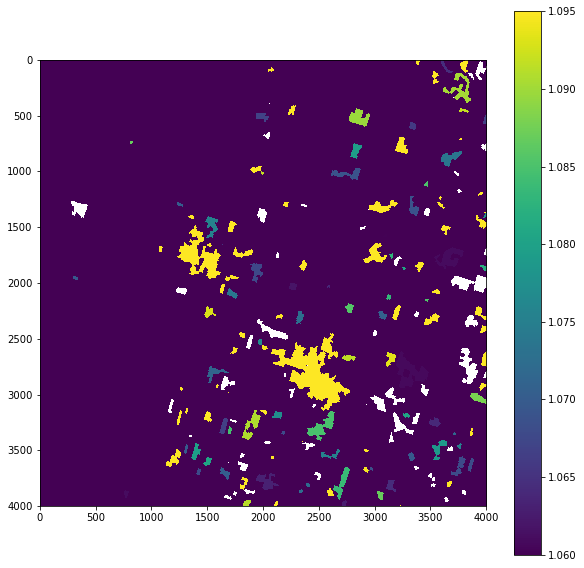

In [292]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(fracdimarray, vmin= 1.060, vmax=1.095)
plt.colorbar()

# Plot processing stages

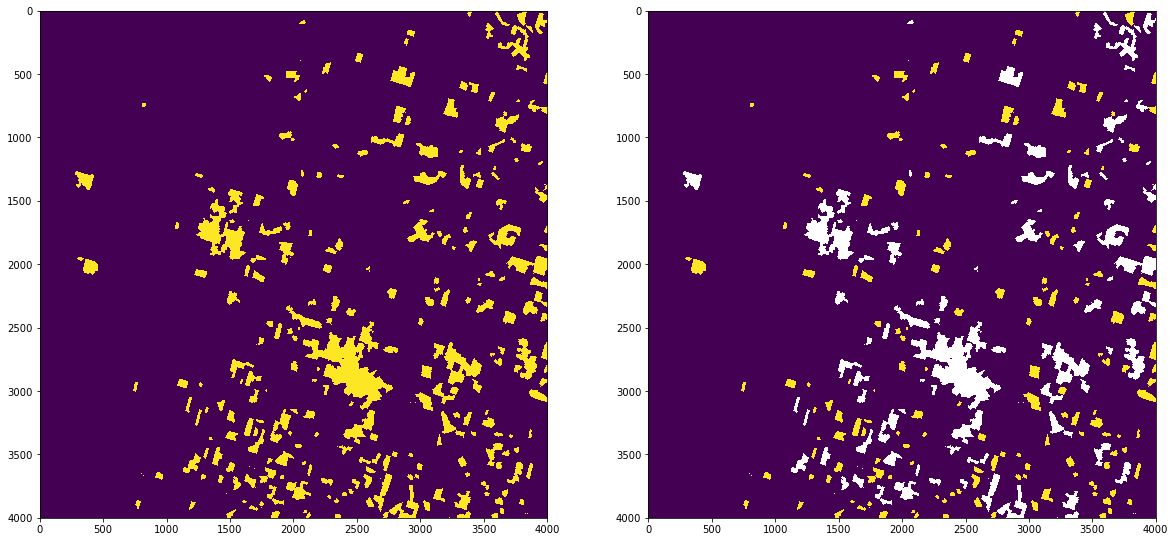

In [298]:
fig, ax = plt.subplots(ncols = 2, figsize=(20,20))
ax[0].imshow(cult_area)
ax[1].imshow(cult_area_fractal)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,20), sharex=True, sharey=True)
ax[0][0].imshow(tmad_pca_seg)
ax[0][0].set_title('TMAD')
ax[0][1].imshow(tv_summary_seg)
ax[0][1].set_title('Fractional cover summary seg')
ax[1][0].imshow(cult_area)
ax[1][0].set_title('MAD + veg')
ax[1][1].imshow(cult_area_filt)
ax[1][1].set_title('Median Filter')
# fig.savefig('cultareaprocess')

# Convert back to xarray / Write out

In [118]:
meta_d = tmad
# meta_d = tmad.squeeze().drop('time')

In [ ]:
x = fc_data.BS.data

In [ ]:
out = np.where(cult_area == True, 1, 0).astype(float)

In [281]:
out = xr.Dataset({'cultfrac':(meta_d.dims,fracdimarray)}, coords=meta_d.coords, attrs=meta_d.attrs)
# out.attrs = meta_d.attrs
# out.attrs['crs']=geometry.CRS(meta_d.crs.attrs['crs_wkt'])

In [128]:
helpers.write_geotiff('blahtbiggerseg.tif', out)

In [ ]:
out.to_netcdf('caf_pca_snowy2.nc')